# Project 2: Planets around TRAPPIST-1 

## Goal and Objectives

Simulate the movements of planets near the star TRAPPIST-1

1. Simulate movement of the 7 closest planets for 10 earth years
2. From which planets can an observer see the most other planets in the night sky?


## Data 

Use pandas during development. Replace with something simpler for project.

In [2]:
import pandas as pd

In [3]:
system = pd.read_hdf("../data/trappist_bodies.hdf5", "LOCAL_UNITS")
system.sort_values('name', inplace=True)

In [4]:
system

,name,mass,period,radius,semi-major,eccentricity
4,b,0.000032,1.510871,1.086,11.11,0.081
2,c,0.000052,2.421823,1.056,15.21,0.083
0,d,0.000015,4.049610,0.772,21.44,0.070
5,e,0.000023,6.099615,0.918,28.17,0.085
1,f,0.000025,9.206690,1.045,37.10,0.063
3,g,0.000050,12.352940,1.127,45.10,0.061
6,h,NaN,20.000000,0.755,63.00,NaN
7,star,1.000000,NaN,0.117,NaN,NaN


In [5]:
planets = system[system['name'] != "star"]
planets = planets.dropna()
star = system[system['name'] == "star"]
M_star = star['mass'].iloc[0]  

assert M_star == 1.0

In [6]:
system_AU = pd.read_hdf("../data/trappist_bodies.hdf5", "SOLAR_UNITS")
M_star_in_solar_mass = system_AU[system_AU['name'] == "star"]['mass'].item()
print(M_star_in_solar_mass)

0.0802


In [129]:
# radius of the star in 10^-3 AU
star_radius_localunits = system_AU[system_AU.name == "star"]['radius'].item() * 1e3
print(star_radius_localunits)

0.0025310706067543276


In [7]:
planets

,name,mass,period,radius,semi-major,eccentricity
4,b,0.000032,1.510871,1.086,11.11,0.081
2,c,0.000052,2.421823,1.056,15.21,0.083
0,d,0.000015,4.049610,0.772,21.44,0.070
5,e,0.000023,6.099615,0.918,28.17,0.085
1,f,0.000025,9.206690,1.045,37.10,0.063
3,g,0.000050,12.352940,1.127,45.10,0.061


## Kepler orbits
See Wang Ch 4.2.3

Orbits with sun at one focus (origin). $r_\text{max}$ is the distance of the sun to the aphelion (farthest) point of orbit; $r_\text{min}$ to perihelion. $a$ is the semi-major axis.

$$
r_\text{max} = a(1+e)\\
r_\text{min} = a(1-e)
$$

The velocity at the aphelion is

$$
v_\text{ap} = \sqrt{\frac{k}{ma} \frac{1-e}{1+e}} = \sqrt{\frac{GM}{a} \frac{1-e}{1+e}}
$$

with

$$
k = GmM
$$


In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

# in AU (solar system) units
#G = 4*np.pi**2

# length = 1e-3 AU, time = d, M = M_star
G = 4*np.pi**2 * (1e3)**3 / (365.25)**2 * M_star_in_solar_mass

In [9]:
def rmax(a, e):
    return a*(1+e)

def v_aphelion(a, e, M):
    return np.sqrt(G*M*(1-e)/(a*(1+e)))

In [10]:
planets_x = rmax(planets['semi-major'], planets['eccentricity'])
planets_vy = v_aphelion(planets['semi-major'], planets['eccentricity'], M=M_star)

In [82]:
def F_gravity(r, m, M=1.0):
    rr = np.sum(r*r)
    rhat = r/np.sqrt(rr)
    return G*m*M/rr * rhat

def U_gravity(r, m, M=1.0):
    return -G*m*M/np.sqrt(np.sum(r*r))

In [83]:
def planet_orbit(r0, v0, mass, M_star=M_star, dt=0.001, t_max=1):
    """2D planetary motion with velocity verlet"""
    dim = len(r0)
    assert len(v0) == dim

    nsteps = int(t_max/dt)

    r = np.zeros((nsteps, dim))
    v = np.zeros_like(r)

    r[0, :] = r0
    v[0, :] = v0

    # start force evaluation for first step
    Ft = F_gravity(-r[0], m=mass, M=M_star)
    for i in range(nsteps-1):
        vhalf = v[i] + 0.5*dt * Ft/mass
        r[i+1, :] = r[i] + dt * vhalf
        Ftdt = F_gravity(-r[i+1], m=mass, M=M_star)
        v[i+1] = vhalf + 0.5*dt * Ftdt/mass
        # new force becomes old force
        Ft = Ftdt
    
    return r, v

Orbit of TRAPPIST-b (without any additional interactions): establish basic values for run parameters.

In [84]:
idx = planets[planets['name'] == 'b'].index
r0 = np.array([planets_x[idx].item(), 0])
v0 = np.array([0, planets_vy[idx].item()])
mass = planets['mass'][idx].item()

In [85]:
r, v = planet_orbit(r0, v0, mass=mass, M_star=M_star, t_max=1.5, dt=0.01)

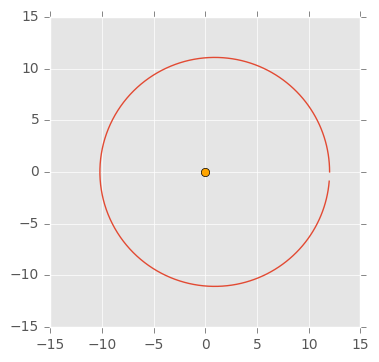

In [86]:
rx, ry = r.T
ax = plt.subplot(1,1,1)
ax.set_aspect(1)
ax.plot(rx, ry)
ax.plot([0], [0], 'o', color="orange")

Looks ok.

In [16]:
planets

,name,mass,period,radius,semi-major,eccentricity
4,b,0.000032,1.510871,1.086,11.11,0.081
2,c,0.000052,2.421823,1.056,15.21,0.083
0,d,0.000015,4.049610,0.772,21.44,0.070
5,e,0.000023,6.099615,0.918,28.17,0.085
1,f,0.000025,9.206690,1.045,37.10,0.063
3,g,0.000050,12.352940,1.127,45.10,0.061


## Many body system 

### Star fixed
Assume that the central star (TRAPPIST1a) can be approximated as fixed.

In [87]:
def orbits(r0, v0, masses, M_star=M_star, dt=0.001, t_max=1):
    """2D planetary motion with velocity verlet for multiple planets"""
    N_bodies = len(masses)
    assert r0.shape[0] == N_bodies
    dim = r0.shape[1]
    assert np.all(v0.shape == r0.shape)

    nsteps = int(t_max/dt)

    r = np.zeros((nsteps, N_bodies, dim))
    v = np.zeros_like(r)

    r[0, :, :] = r0
    v[0, :, :] = v0

    # start force evaluation for first step
    Ft = forces(r[0], masses, M_star)
    for i in range(nsteps-1):
        vhalf = v[i] + 0.5*dt * Ft/masses[:, np.newaxis]
        r[i+1, :] = r[i] + dt * vhalf
        Ftdt = forces(r[i+1], masses, M_star)
        v[i+1] = vhalf + 0.5*dt * Ftdt/masses[:, np.newaxis]
        # new force becomes old force
        Ft = Ftdt
    return r, v

def forces(r, masses, M):
    F = np.zeros_like(r)
    for i, m in enumerate(masses):
        # planet - star (note: minus sign to be consistent with rij!)
        F[i, :] = F_gravity(-r[i], m=m, M=M)
        for j in range(i+1, len(masses)):
            # force of planet j on i
            rij = r[j] - r[i]
            Fij = F_gravity(rij, m=m, M=masses[j])
            F[i] += Fij
            # Newton's 3rd law:
            Fji = -Fij
            F[j] += Fji
    return F
            

In [88]:
r0 = np.array([planets_x, np.zeros_like(planets_x)]).T
v0 = np.array([np.zeros_like(planets_vy), planets_vy]).T
masses = planets['mass'].values

In [89]:
forces(r0, masses, M_star)

array([[-0.00523389,  0.        ],
       [-0.00451814,  0.        ],
       [-0.00069199,  0.        ],
       [-0.00058942,  0.        ],
       [-0.00038804,  0.        ],
       [-0.00051998, -0.        ]])

In [90]:
r, v = orbits(r0, v0, masses, t_max=5, dt=0.01)

In [91]:
r.shape

(500, 6, 2)

In [92]:
def plot_orbits(r):
    ax = plt.subplot(111)
    ax.set_aspect(1)
    for planet in range(r.shape[1]):
        rx, ry = r[:, planet, :].T
        ax.plot(rx, ry)
        ax.plot(rx[-1], ry[-1], 'o', ms=4, color="gray", alpha=0.5)
    ax.plot([0], [0], 'o', ms=15, color="orange")
    return ax

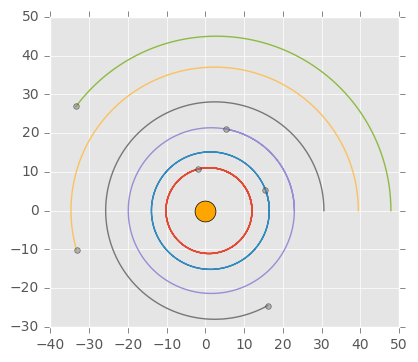

In [93]:
plot_orbits(r)

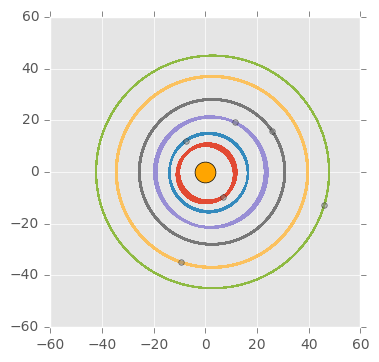

In [94]:
r, v = orbits(r0, v0, masses, t_max=1000, dt=0.01)
plot_orbits(r)

### Star moves
Include movement of the central star (TRAPPIST1a). Choose initial conditions so that the total momentum of the system is zero.

In [95]:
def orbits2(r0, v0, masses, M_star=M_star, dt=0.001, t_max=1):
    """2D planetary motion with velocity verlet for multiple planets and star."""
    N_bodies = len(masses)
    assert r0.shape[0] == N_bodies
    dim = r0.shape[1]
    assert np.all(v0.shape == r0.shape)

    nsteps = int(t_max/dt)

    r = np.zeros((nsteps, N_bodies, dim))
    v = np.zeros_like(r)

    r[0, :, :] = r0
    v[0, :, :] = v0

    # start force evaluation for first step
    Ft = forces2(r[0], masses)
    for i in range(nsteps-1):
        vhalf = v[i] + 0.5*dt * Ft/masses[:, np.newaxis]
        r[i+1, :] = r[i] + dt * vhalf
        Ftdt = forces2(r[i+1], masses)
        v[i+1] = vhalf + 0.5*dt * Ftdt/masses[:, np.newaxis]
        # new force becomes old force
        Ft = Ftdt
        if np.linalg.norm(Ft.sum(axis=0)) > 1e-12:
            print("Violation of Newton's 3rd law: F = {}".format(Ft))
    return r, v

def forces2(r, masses):
    F = np.zeros_like(r)
    for i, m in enumerate(masses):
        for j in range(i+1, len(masses)):
            # force of body j on i
            rij = r[j] - r[i]
            Fij = F_gravity(rij, m=m, M=masses[j])
            F[i] += Fij
            # Newton's 3rd law:
            Fji = -Fij
            F[j] += Fji
    return F
            

In [96]:
# planets 
r0 = np.array([planets_x, np.zeros_like(planets_x)]).T
v0 = np.array([np.zeros_like(planets_vy), planets_vy]).T
masses = planets['mass'].values

# prepend star
r0_system = np.vstack((np.array([[0, 0]]), r0))

# choose star velocity to make total momentum 0
p_planets = np.sum(masses[:, np.newaxis] * v0, axis=0)
v0_star = -p_planets / M_star
v0_system = np.vstack((v0_star, v0))

masses_system = np.concatenate(([M_star], masses))

In [97]:
r0_system

array([[  0.     ,   0.     ],
       [ 12.00991,   0.     ],
       [ 16.47243,   0.     ],
       [ 22.9408 ,   0.     ],
       [ 30.56445,   0.     ],
       [ 39.4373 ,   0.     ],
       [ 47.8511 ,   0.     ]])

In [98]:
v0_system

array([[ -0.00000000e+00,  -6.01597122e-03],
       [  0.00000000e+00,   4.26152173e+01],
       [  0.00000000e+00,   3.63481792e+01],
       [  0.00000000e+00,   3.10180165e+01],
       [  0.00000000e+00,   2.66550243e+01],
       [  0.00000000e+00,   2.37461407e+01],
       [  0.00000000e+00,   2.15806073e+01]])

In [99]:
f0 = forces2(r0_system, masses_system)
print(f0)
f0.sum(axis=0)

[[ 0.01194524  0.        ]
 [-0.00523389  0.        ]
 [-0.0045201   0.        ]
 [-0.00069254  0.        ]
 [-0.00058976  0.        ]
 [-0.00038834  0.        ]
 [-0.00052062  0.        ]]


array([  1.40946282e-18,   0.00000000e+00])

In [133]:
r, v = orbits2(r0_system, v0_system, masses_system, t_max=5, dt=0.01)

In [134]:
r.shape

(500, 7, 2)

In [135]:
def plot_orbits(r):
    ax = plt.subplot(111)
    ax.set_aspect(1)
    for planet in range(r.shape[1]):
        rx, ry = r[:, planet, :].T
        ax.plot(rx, ry)
        ax.plot(rx[-1], ry[-1], 'o', ms=4, color="gray", alpha=0.5)
    return ax

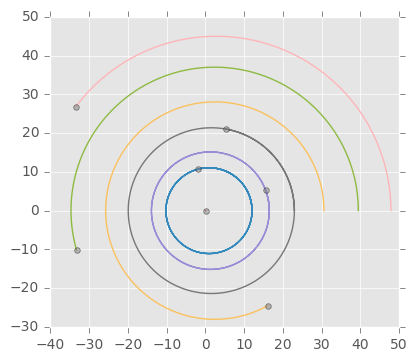

In [136]:
plot_orbits(r)

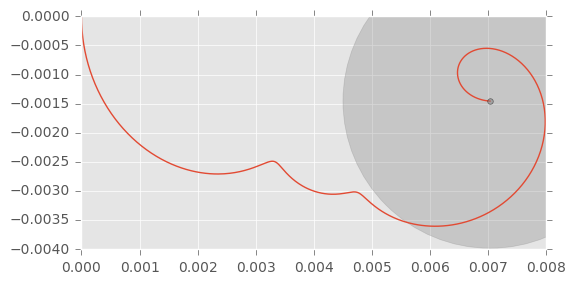

In [137]:
r_star = r[:, 0][:, np.newaxis, :]
plot_orbits(r_star)
star_size = plt.Circle(r_star[-1, 0], star_radius_localunits, color='gray', alpha=0.3)
plt.gcf().gca().add_artist(star_size);

Now for 1000 d:

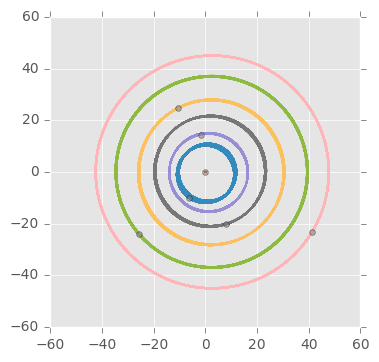

In [138]:
r, v = orbits2(r0_system, v0_system, masses_system, t_max=1000, dt=0.01)
plot_orbits(r)

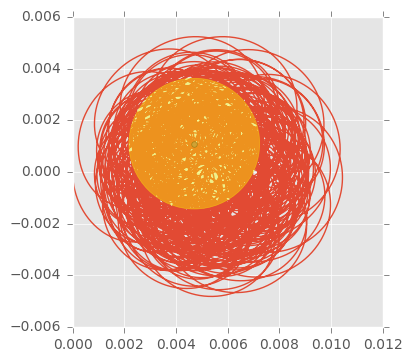

In [149]:
r_star = r[:, 0][:, np.newaxis, :]
plot_orbits(r_star)
star_size = plt.Circle(r_star[-1, 0], star_radius_localunits, color='yellow', alpha=0.4, zorder=2)
plt.gcf().gca().add_artist(star_size);

The orbit of the star TRAPPIST-1a extends farther than the size of the star. Thus the common center of mass of the system is outside the star itself and a wobble should be observable.